In [115]:
#Libraries
import sys
import pandas as pd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

In [116]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("seaborn", sns.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)] 

library    version
------------------
matplotlib  3.7.5
numpy       1.26.4
pandas      2.2.3
seaborn     0.13.2


#### 1. Exploratory Data Analysis (EDA): 

In this section, I perform an exploratory data analysis to gain a better understanding of the day-ahead electricity price data. The goal is to explore the distribution, variability, and general patterns within the dataset.

Specifically, I will:

- Compute descriptive statistics (mean, median, min, max, standard deviation) of electricity prices.
- Examine how electricity prices vary throughout the day for each country.
- Compare price volatility between countries.

Insights from this stage will guide the further stages of my analysis

In [117]:
data = pd.read_csv("electricity_dah_prices.csv")
data.head()

,date,hour,france,italy,belgium,spain,uk,germany
0,2022/01/01,00:00 - 01:00,89.06,170.28,82.02,145.86,0.27,50.05
1,2022/01/01,01:00 - 02:00,78.48,155.72,67.07,114.90,-0.01,41.33
2,2022/01/01,02:00 - 03:00,85.16,147.09,75.11,113.87,0.27,43.22
3,2022/01/01,03:00 - 04:00,50.00,91.00,50.91,97.80,-0.01,45.46
4,2022/01/01,04:00 - 05:00,37.67,104.00,37.67,97.80,-0.01,37.67


In [118]:
data.shape

(8761, 8)

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     8761 non-null   object 
 1   hour     8761 non-null   object 
 2   france   8760 non-null   float64
 3   italy    8760 non-null   float64
 4   belgium  8760 non-null   float64
 5   spain    8760 non-null   float64
 6   uk       7319 non-null   float64
 7   germany  8760 non-null   float64
dtypes: float64(6), object(2)
memory usage: 547.7+ KB


In [120]:
data.describe(include='object')

,date,hour
count,8761,8761
unique,365,24
top,2022/10/30,02:00 - 03:00
freq,25,366


In [121]:
#Combine date and hour into a single datetime column
data['hour'] = data['hour'].astype(str).str[:5]
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['hour'], format='%Y/%m/%d %H:%M')

data.drop(columns=['date', 'hour'], inplace=True)
data.set_index('datetime', inplace=True)

In [122]:
data.isnull().sum()

france        1
italy         1
belgium       1
spain         1
uk         1442
germany       1
dtype: int64

C:\Users\larbi\AppData\Local\Temp\ipykernel_26932\2132442321.py:3: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2 = data.interpolate(method='pad')


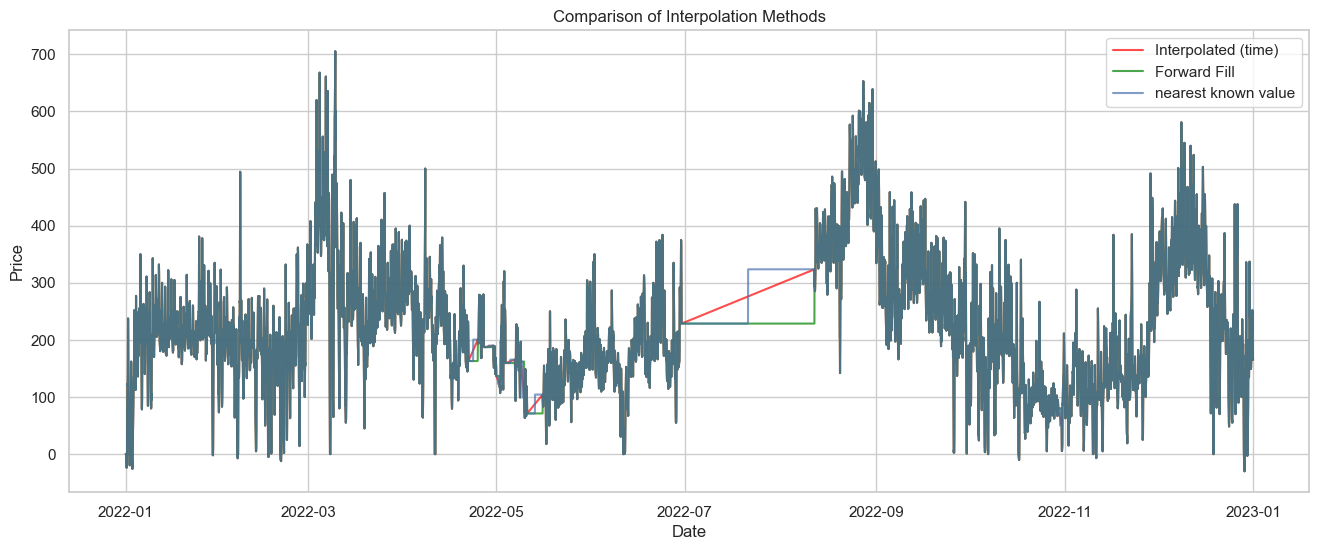

In [123]:
# Interpolate missing values
df1 = data.interpolate(method='time')
df2 = data.interpolate(method='pad')
df3 = data.interpolate(method='nearest')

plt.figure(figsize=(16, 6))
plt.plot(df1['uk'], label='Interpolated (time)', alpha=0.7, color='red')         
plt.plot(df2['uk'], label='Forward Fill', alpha=0.7, color='green')               
plt.plot(df3['uk'], label='nearest known value', alpha=0.7)    

plt.title('Comparison of Interpolation Methods')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [124]:
# Interpolate missing values using time method
data = data.interpolate(method='time')
data.head()

,france,italy,belgium,spain,uk,germany
datetime,,,,,,
2022-01-01 00:00:00,89.06,170.28,82.02,145.86,0.27,50.05
2022-01-01 01:00:00,78.48,155.72,67.07,114.90,-0.01,41.33
2022-01-01 02:00:00,85.16,147.09,75.11,113.87,0.27,43.22
2022-01-01 03:00:00,50.00,91.00,50.91,97.80,-0.01,45.46
2022-01-01 04:00:00,37.67,104.00,37.67,97.80,-0.01,37.67


<Figure size 1600x600 with 0 Axes>

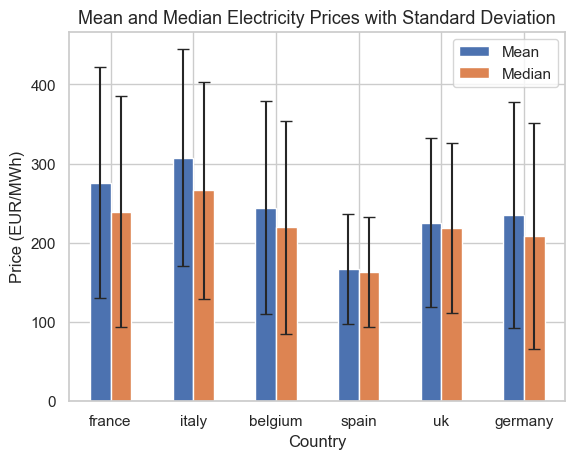

In [125]:
stats_summary = data.describe().T
stats_summary['mean'] = data.mean() 
stats_summary['median'] = data.median()
stats_summary['std'] = data.std()

# Visualization of basic descriptive statistics
plt.figure(figsize=(16, 6))
stats_summary[['mean', 'median']].plot(kind='bar', yerr=stats_summary['std'], capsize=4)
plt.title('Mean and Median Electricity Prices with Standard Deviation', size="13")
plt.xlabel('Country')
plt.ylabel('Price (EUR/MWh)')
plt.xticks(rotation=0)
plt.legend(['Mean', 'Median'])
plt.show()

**Interpretation**

This bar chart compares the mean and median electricity prices (EUR/MWh) for France, Italy, Belgium, Spain, UK, and Germany with std as error bars. Italy has the highest mean and median prices, suggesting higher electricity costs. Spain has the lowest and most stable average prices with relatively small variability, indicating consistent market pricing. While, Belguim, Germany and France have similar volatility, France shows a noticeable difference between mean and median, indicating potential outliers or skewness due to extreme price spikes.

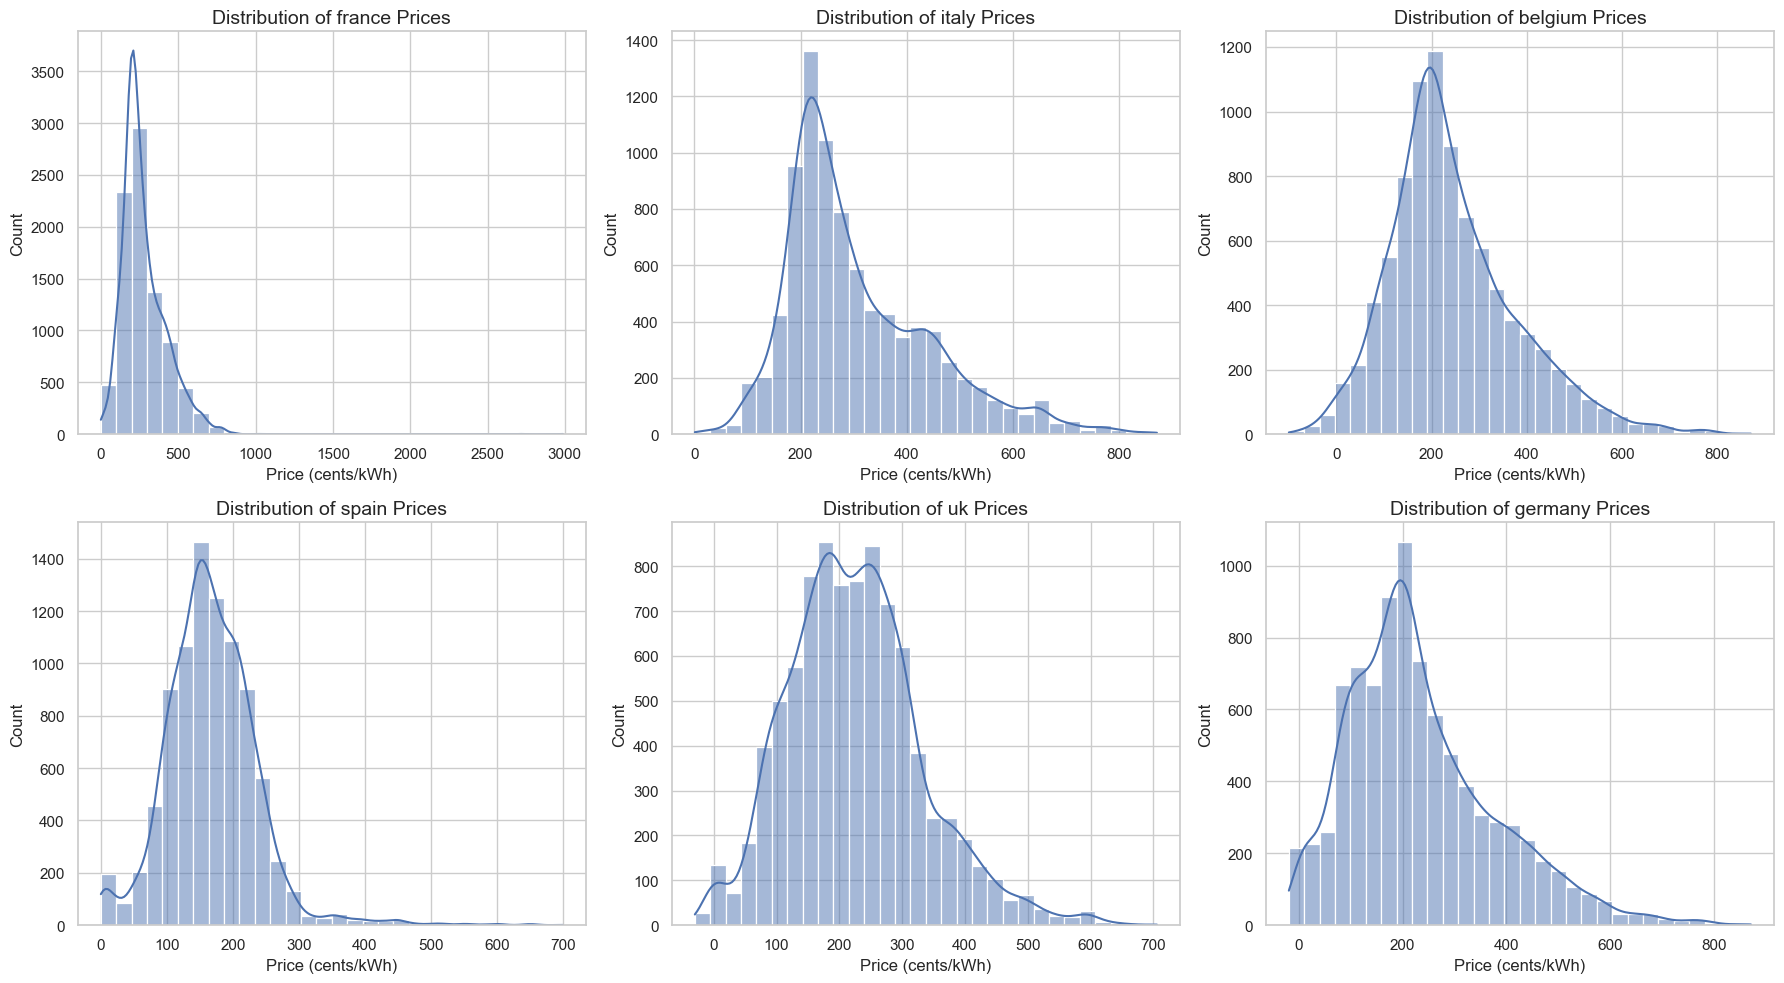

In [126]:
#Price distribution visualization by country
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, x in enumerate(data.columns):
    sns.histplot(data[x], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {x} Prices', size=14)
    axes[i].set_xlabel('Price (cents/kWh)')
    axes[i].set_ylabel('Count')

# Hide any unused subplots if there are less than 6 columns
for j in range(len(data.columns), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Interpretation:**

These charts compare the distribution of electricity prices across countries, offering a quick way to identify differences in market behavior, volatility, and the presence of outliers.

- France: Prices cluster in the lower range, with occasional extreme spikes above 1,000 cents/kWh, indicating that prices are usually low to moderate but can experience rare, substantial surges.
- Italy, Germany, and Belgium: These countries share similar distributions with moderately high variability and comparable median prices (200 cents/kwh). However, Germany exhibits more frequent high-price events and Belgium prices have some negative outliers, which may indicate periods of surplus production or anomalies in pricing mechanisms.
- Spain and the UK: Both display narrower distributions, suggesting more stable market conditions with fewer extreme price fluctuations.

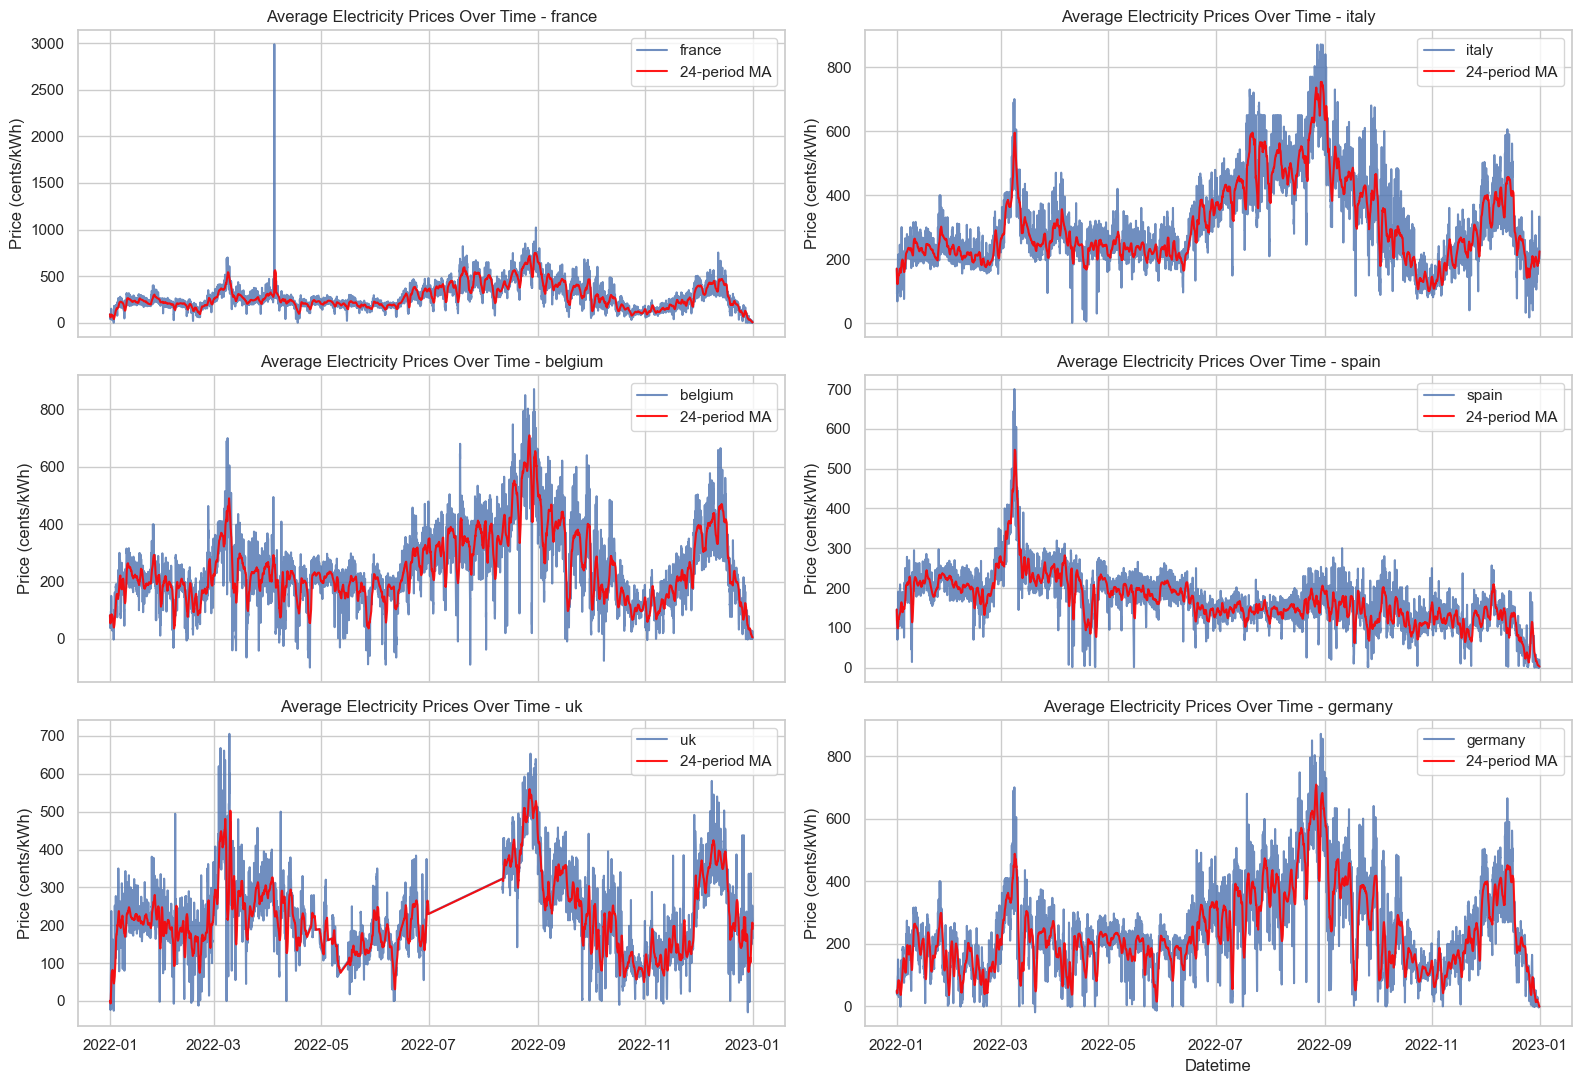

In [127]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(16, 11), sharex=True)
axes = axes.flatten()

window = 24  #Daily moving average since our data is hourly

# Plot each country's prices with a moving average
for i, col in enumerate(data.columns):
    axes[i].plot(data.index, data[col], label=col, alpha=0.8)
    # Add moving average
    axes[i].plot(data.index, data[col].rolling(window=window, min_periods=1).mean(), label=f'{window}-period MA', 
                 color='red', alpha=0.9)
    axes[i].set_title(f'Average Electricity Prices Over Time - {col}')
    axes[i].set_ylabel('Price (cents/kWh)')
    axes[i].legend()

axes[-1].set_xlabel('Datetime')
plt.tight_layout()
plt.show()

**Interpretation:**

- Q1 2022: Most countries show spikes around March, likely tied to seasonal demand shifts or geopolitical shocks (e.g., energy market disruptions from the Russia–Ukraine conflict).

- Mid-2022: Italy, Germany, and Belgium experience prolonged high-price periods, possibly due to supply shortages or reduced imports.

- Late 2022: Prices ease in most markets, aligning with improved supply stability or demand reduction measures.

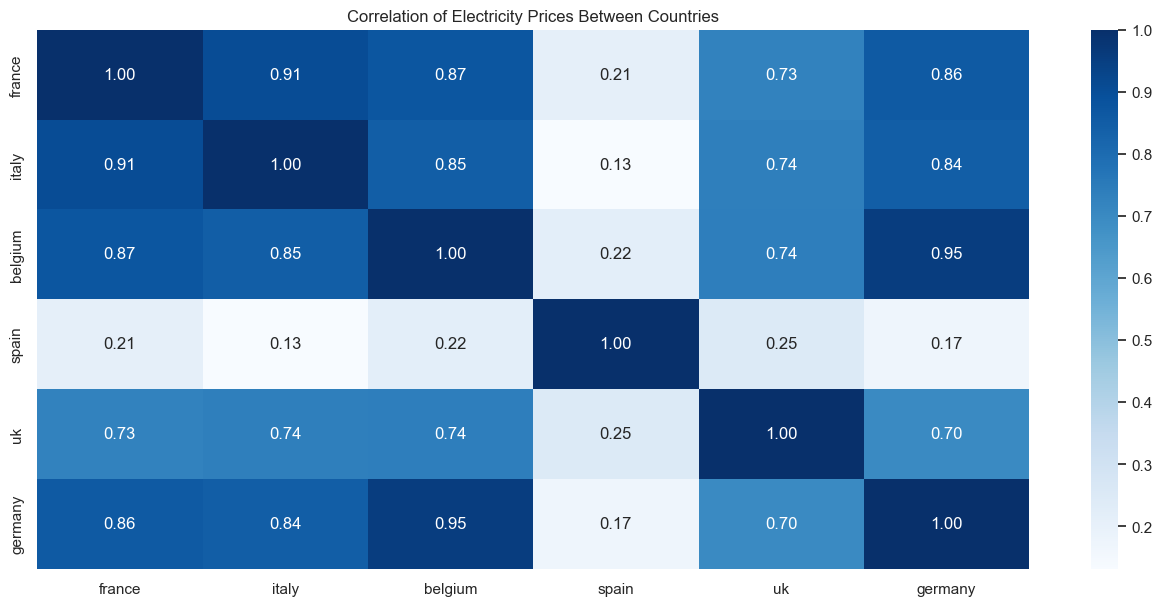

In [128]:
# Correlation matrix between countries
correlation_matrix = data[['france', 'italy', 'belgium', 'spain', 'uk', 'germany']].corr()

plt.figure(figsize=(16, 7))

""" annot=True to dispaly correlation values -- fmt='.2f' for formatting the correlation values """
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')

plt.title('Correlation of Electricity Prices Between Countries')
plt.show()

**Interpretation:**

- France, Belgium, and Germany show strong positive correlations (0.87 - 0.96), indicating highly integrated electricity markets and similar pricing dynamics among these neighboring countries.

- Spain has notably weaker correlations (0.20 - 0.30) with other countries, reflecting a more independent price dynamic possibly due to geographical constraints, or different energy production methods.

#### 2. Time Series Analysis:

In this section, I perform time series analysis on Germany electricity price data to identify key components such as trends, seasonal patterns, and residual variations. Understanding these components helps to interpret the data more effectively and uncover important insights into market behavior over time.

**Germany**

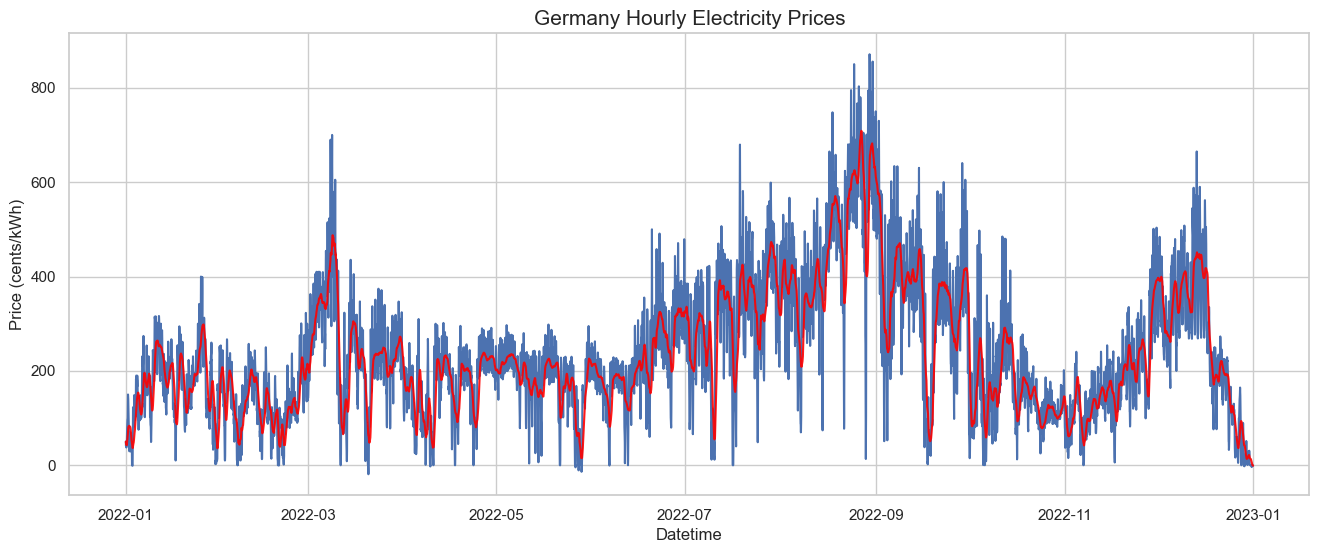

In [129]:
plt.figure(figsize=(16,6))
plt.plot(data.index, data['germany'], label="hourely prices")
plt.plot(data.index, data['germany'].rolling(window=24, min_periods=1).mean(), label='24-hour MA', color='red', alpha=0.9)
plt.title('Germany Hourly Electricity Prices', fontsize=15)
plt.xlabel('Datetime')
plt.ylabel('Price (cents/kWh)')
plt.show()

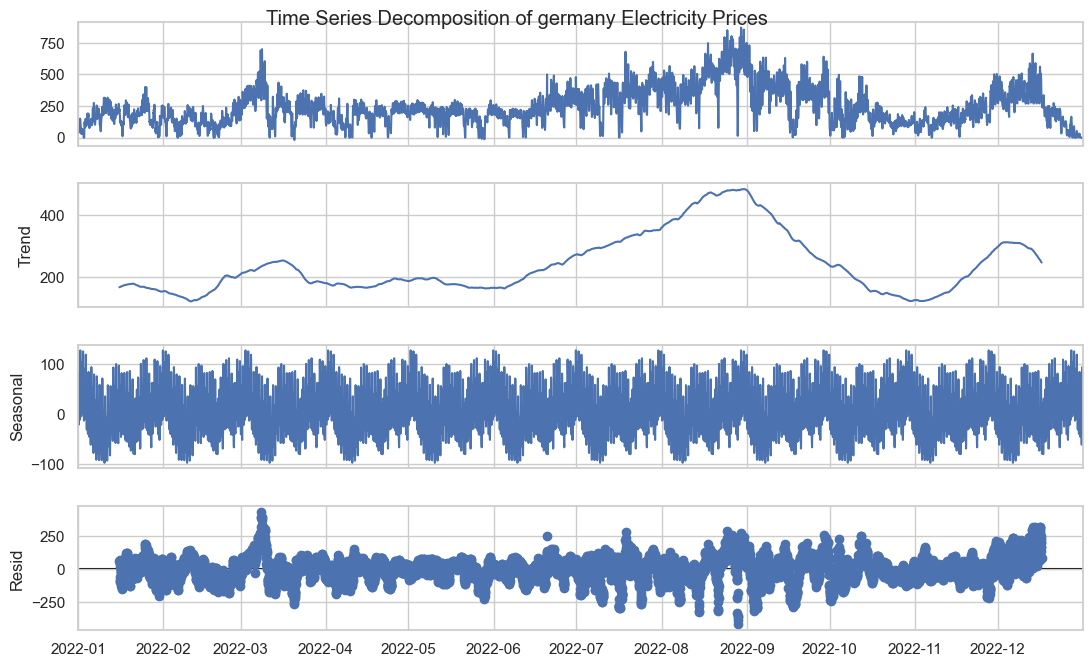

In [ ]:
#Trend, seasonality, and residuals decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data[['germany']], model='additive', period=24*30)

# Plot decomposition results
fig = decomposition.plot()
fig.set_size_inches(12, 7)
fig.suptitle('Time Series Decomposition of Germany Electricity Prices')
plt.show()

**Interpretation:**
- Trend: shows a gradual rise starting mid-June, peaking around late August to early September at over 400 cents/kWh. After the peak, the trend declines sharply until November, then slightly rebounds in December. The trend indicate a seasonal or supply-driven mid-year price increase followed by easing toward winter.
- Seasonality: is stable and repetitive, indicating demand cycles remained predictable despite fluctations 
- Residuals: positive spikes around March and Auguest corresponding to increase in electricity market prices compared to negative spikes around september, which reflects sudden drops

Anomalies detected: 221
Lower bound: -129.59499999999994, Upper bound: 573.885


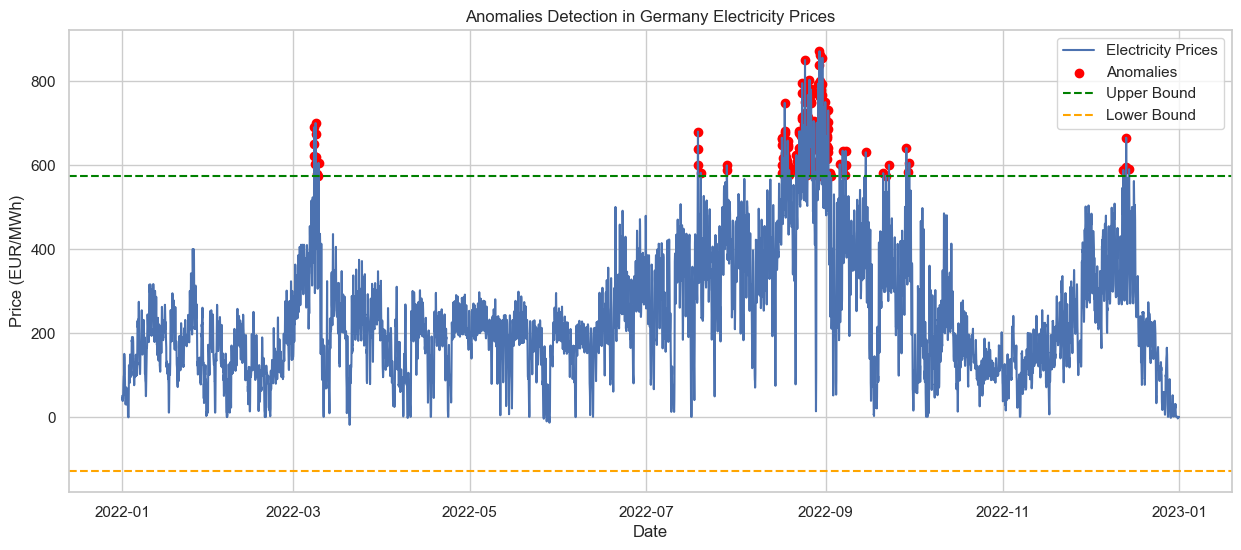

In [161]:
#Anomalies detection using statistical methods (Interquartile Range - IQR) 
germany_prices = data['germany'].copy()

# Define function to detect anomalies using IQR method
def detect_anomalies(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    anomalies = data[(data < lower_bound) | (data > upper_bound)]
    return anomalies, lower_bound, upper_bound

anomalies, lower_bound, upper_bound = detect_anomalies(germany_prices)

print(f"Anomalies detected: {len(anomalies)}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

# Plot anomalies
plt.figure(figsize=(15,6))
plt.plot(germany_prices, label='Electricity Prices')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies')
plt.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.axhline(y=lower_bound, color='orange', linestyle='--', label='Lower Bound')
plt.title('Anomalies Detection in Germany Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWh)')
plt.legend()
plt.show()

#### 3. Electricity Price Forecasting: 

In this section, I apply different forecasting models to predict electricity prices in France. The models used include:
- ARIMA: A classical time series model capturing autoregressive and seasonal components
- SARIMA
- LSTM